In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [23]:
def bachelier_formula(t, St, T, sigma, K):
    d_time = T - t
    d_price = St - K
    return sigma ** 2 * d_time * stats.norm.pdf(d_price / (sigma ** 2 * d_time)) + d_price * stats.norm.cdf(d_price / (sigma ** 2 * d_time))

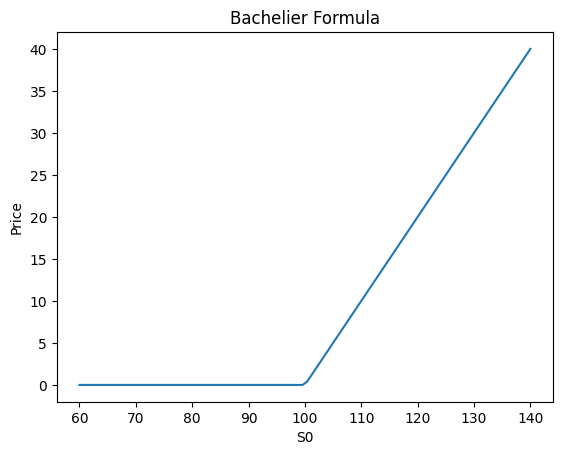

In [24]:
sigma = 0.2
T = 1
K = 100
t = 0

S0s = np.linspace(60, 140, 100)
prices = bachelier_formula(t, S0s, T, sigma, K)

plt.plot(S0s, prices)
plt.xlabel('S0')
plt.ylabel('Price')
plt.title('Bachelier Formula')
plt.show()

In [25]:
def generate_Sts(S0, T, sigma, N):
    dt = T / N
    return S0 + np.cumsum(np.random.normal(0, sigma * np.sqrt(dt), N))

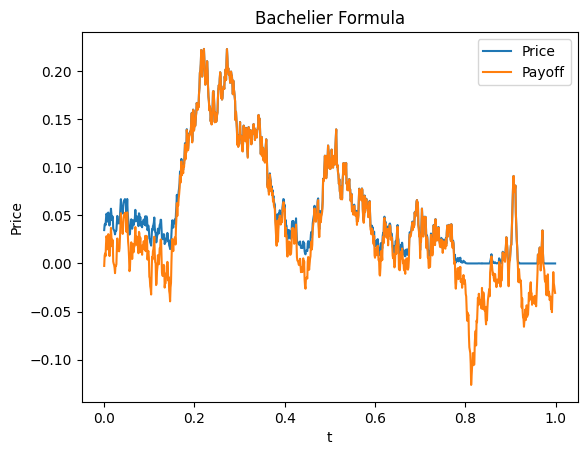

In [36]:
sigma = 0.3
T = 1
K = 100
S0 = 100

ts = np.linspace(0, T - 1/1000, 1000)
Sts = generate_Sts(S0, T, sigma, ts.size)
prices = bachelier_formula(ts, Sts, T, sigma, K)

plt.plot(ts, prices, label='Price')
plt.plot(ts, Sts - K, label='Payoff')
plt.xlabel('t')
plt.ylabel('Price')
plt.legend()
plt.title('Bachelier Formula')
plt.show()

In [38]:
print(np.cov(prices, Sts - K))

[[0.00307432 0.00359087]
 [0.00359087 0.00443605]]
